In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier

### 1)

In [2]:
df = pd.read_csv('taxi.csv')

### 2)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [4]:
df.head(5)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [5]:
df['offer_gk'].nunique(), df.shape[0]

(100000, 100000)

### Наибольшее число предложений наблюдается на 5,6 день (выходные)

In [6]:
df['weekday_key'].value_counts() / df.shape[0]

5    0.19284
6    0.15466
0    0.14411
4    0.13290
1    0.13089
2    0.12859
3    0.11601
Name: weekday_key, dtype: float64

In [7]:
### Количество предложений растёт ближе к ночи (пик ~23:00)

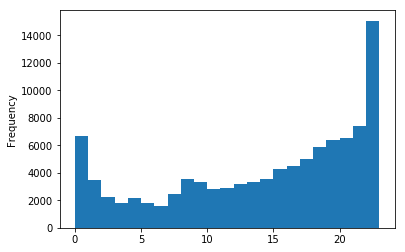

In [8]:
df['hour_key'].plot.hist(bins = range(0,24))

In [9]:
df['driver_gk'].nunique()

439

In [10]:
df['order_gk'].nunique()

81435

In [11]:
df[['driver_latitude','driver_longitude','origin_order_latitude','origin_order_longitude']].describe()

,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,55.700824,37.492292,55.772440,37.541637
std,2.135903,1.454640,0.665985,0.467758
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,55.708651,37.413497,55.708032,37.407117
50%,55.772904,37.533664,55.772561,37.532537
75%,55.960667,37.624113,55.962000,37.624358
max,56.174097,38.280547,56.311121,38.243608


### По мере роста расстояния, число поездок уменьшается
### При этом присутствует интересный пик в районе 40km

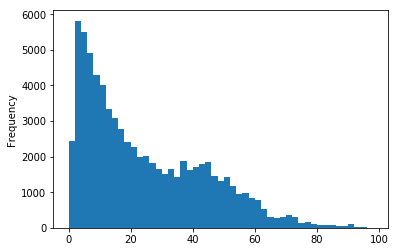

In [12]:
df['distance_km'].plot.hist(bins=range(0,100,2))

In [13]:
df[df['distance_km'] > 100].shape[0]

175

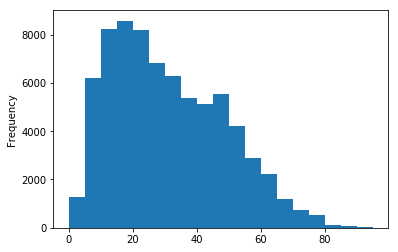

In [14]:
df['duration_min'].plot.hist(bins=range(0,100,5))

In [15]:
df[df['duration_min'] > 100].shape[0]

128

In [16]:
df['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [17]:
df['driver_response'].value_counts()

0    50752
1    49248
Name: driver_response, dtype: int64

### 3) В данных отсутствуют явные пропуски

In [18]:
for col in df.columns:
    if df[col].hasnans:
        print(col, df[col].isnull().sum())

### Однако в случае не положительных расстояния и длительности поездки можно считать, что эти данные отсутствуют

In [19]:
df[df['distance_km'] <= 0].shape[0]

26359

In [20]:
df[df['duration_min'] <= 0].shape[0]

26359

In [21]:
df[(df['distance_km'] <= 0) & (df['distance_km'] <= 0)].shape[0]

26359

### Посколько в дальнейшем будут использоваться модели на основе деревьев, нет необходимости заменять пропущенные значения
### Модель сама сможет отделить их при разбиении признака в узле(если это будет повышать качество модели)

### 4)

### Наблюдается сильная корреляция между широтой и долготой объектов, длительностью и длинной поездки

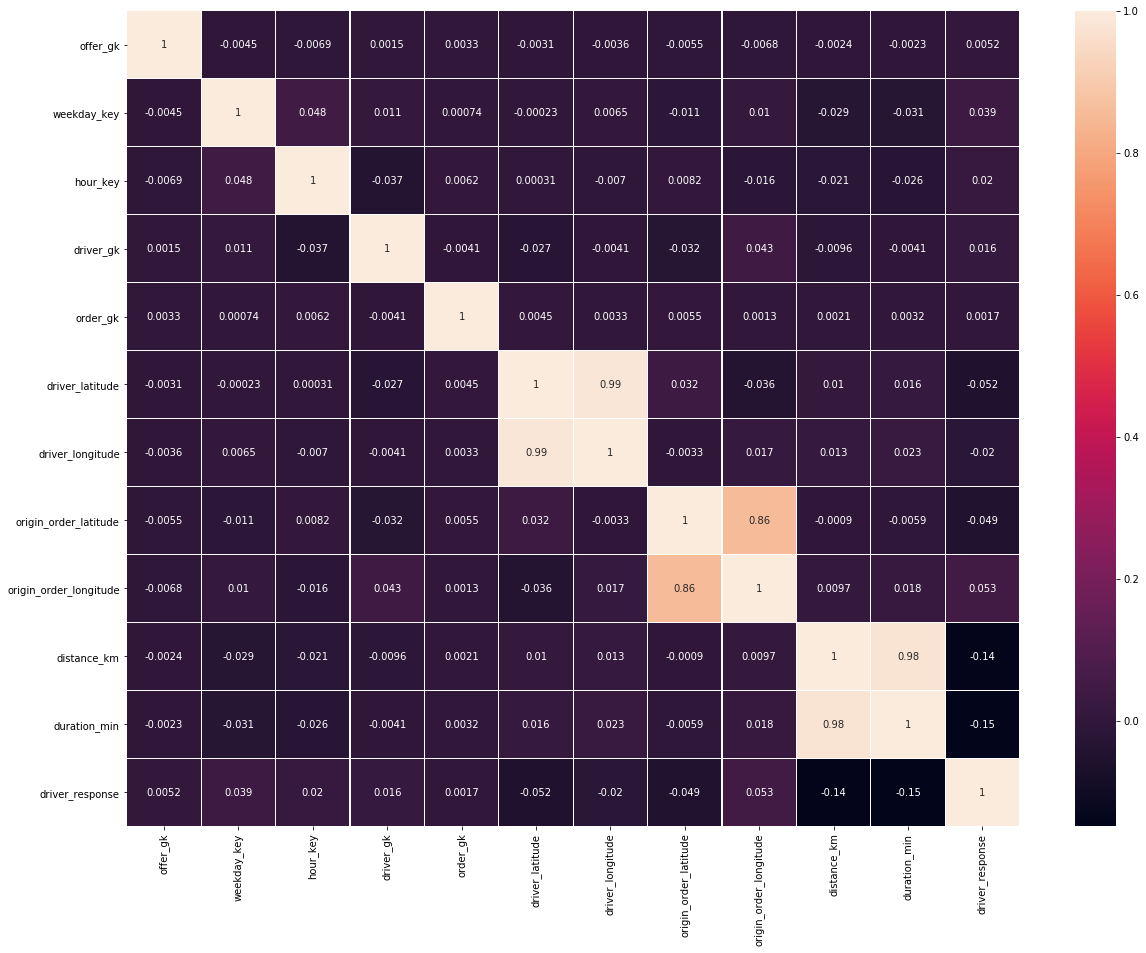

In [22]:
sns.heatmap(df.corr(), annot = True, linewidths=0.3)
fig = plt.gcf()
fig.set_size_inches(20,15)
plt.show()

### 5) Кодирование категориальных переменных

In [23]:
df['ride_type'] = pd.factorize(df['ride_type_desc'])[0]

In [24]:
df['offer_class'] = pd.factorize(df['offer_class_group'])[0]

### 6) Добавление признаков

In [25]:
df['is_weekend'] = df['weekday_key'].map(lambda x: 0 if x <= 4 else 1)

In [26]:
df['lat_dist'] = df['driver_latitude'] - df['origin_order_latitude']
df['lon_dist'] = df['driver_longitude'] - df['origin_order_longitude']

### 7) Разбиение датасета на 2 выборки

In [27]:
df.drop(['weekday_key', 'ride_type_desc', 'offer_class_group'], axis=1, inplace=True)

In [28]:
target = df['driver_response']
df.drop(['driver_response'], axis=1, inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=42)

### 8) Обучение модели

In [30]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8475620254949014

In [32]:
model = XGBClassifier(n_estimators=300)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [33]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8761453633168551

In [34]:
df.columns

Index(['offer_gk', 'hour_key', 'driver_gk', 'order_gk', 'driver_latitude',
       'driver_longitude', 'origin_order_latitude', 'origin_order_longitude',
       'distance_km', 'duration_min', 'ride_type', 'offer_class', 'is_weekend',
       'lat_dist', 'lon_dist'],
      dtype='object')

In [35]:
model = LGBMClassifier(n_jobs=-1, n_estimators=150)
model.fit(X_train, y_train, categorical_feature = [1,2,3,10,11])

/home/lucky/.local/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 2, 3, 10, 11]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9189891722187888

### Как и ожидалось градиентный бустинг над решающими деревьями показывает лучшие результаты, чем случный лес

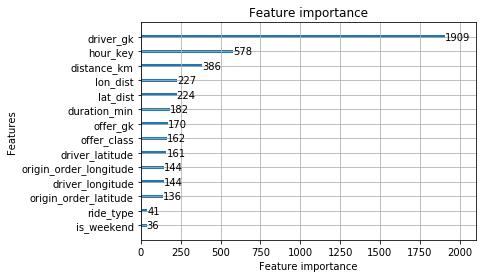

In [37]:
plot_importance(model)